<a href="https://colab.research.google.com/github/ShynPham/pytorch_learning_journey/blob/main/08_PyTorch_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* **What is it**?

  Paper Replicating technique is where you read a research paper from a team of scientist that work and then turn it into code.

* **How can it be useful?**

  It is usefull when you are reseraching a model that work for your own problem.
  It is also usefull to praticing your skills


There are multiple reserach paper and multiple way to replicate it. But once getting the momentum, you will be able to replicate it.

In this notebook, we will be replicating the machine learning research paper of [An Image is Worth16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/1606.08415) with PyTorch.



**Terminology**
There will be a few acronyms throughout the notebook:
1. ***ViT*** - Stands for Vision Transformer(the main neural network architecture we're going to be focused on replicating)
2. ***Vit Paer*** - shorthand for the original macine learning reserac paper that introduced the ViT paper

# 0. Getting setup

* Firstly, we will import all the neccessary Python script we have done so far(e.g `data_setup.py`, `engine.py`, `model_builder.py`, etc.)
> To do so, we'll download `going_modular` directory from 5.Pytorch going Modular notebook(if we haven't done it)
* Next is to download `torchinfo` package since colab doesn't come install with it
* Last ly is to make sure our torchvision model and torch model is lastest version(colab alaways have the lastest)

In [ ]:
# Import with regular library
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Check if torchinfo is download, if not then download it
try:
  from torchinfo import summary
except:
  print(f"[INFO] torchinfo isn't intall, installing it....")
  !pip install -q torchinfo
  from torchinfo import summary



[INFO] torchinfo isn't intall, installing it....


In [ ]:
# Download and import going_modular directory from github
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 14.96 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device acognistic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Download data

Since we're continuing on with FoodVision Mini, let's download the pizza, steak, sushi images data_setup

To do so we will be using download_data() function from `helper_functions.py`

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory path for train and test
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create DataSets and DataLoaders

Samething, we will be using `create_dataloaders()` function in `data_setup.py`

First, we'll create a tranforms to prepare our images

**This is where one of the first reference to the ViT paper will come in**
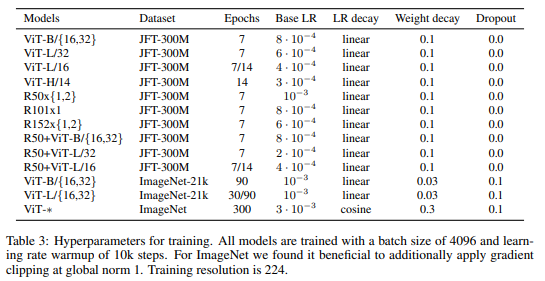

> Source: Table 3 page 13 in [ViT](https://arxiv.org/pdf/2010.11929)

We see that the paper mention the training resolution is being 224(height=224, width=224)

We'll use that information to resies our images appropriately

## 2.1 Prepare transform for images

Make sure the image size is **224** for both height and width

In [ ]:
# Create image size that met with the ViT paper
IMAGE_SIZE = 224

# Createa transform pipline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
print(f"Manual created transforms: {manual_transforms}")

Manual created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 2.2 Turn images into `DataLoader`'s

The paper mention that they use a batch size of 4096 which is 128x the size of the batch we've been using (32)

But for our own problem, we will be sticking with batch_size of 32

Why?

Because batch_size of 4096 is a big batch size and need a lot of GPU memory to be able to caculated with it.



In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7909b4b1fdd0>,
 ['pizza', 'steak', 'sushi'])

# 2.3 Visualize a single image

An important step in the ViT paper is preparing the images into patches.

So we need to visualize, visualize, visualize!!

Let's view a single images and its label


In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

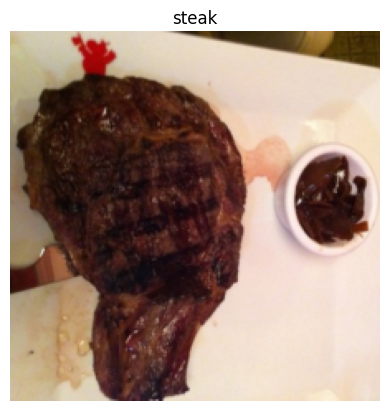

In [ ]:
# Plot the image with mathplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimension to suit matplotlib [C, H, W] -> [H, W C]
plt.title(class_names[label.item()])
plt.axis(False)

# 3. Replicating the ViT paper: an overview

Before we code, we need to understand what we read and what we need to download_data

1. W'd like to replicated the ViT paper for our own problem, FoodVision Mini
2. Our model input are: datasets image of pizza, steak and sushi
  2.1 So the ideal model outputs are: predicted labels of pizza, steak, sushi

Question is: How do we go from our input to the desired output

>  By breaking down into smaller peices:
  * **Inputs** -  What goes into the model? (in our case, image tensor)
  * **Output** - What come out of the model/layer/block?(in our case, we want the modl to output imaeg classification)
  * **Layers** - Takes an input, manipulates itt with a functiton
  * **Blocks** - A collection of layers
  * **Model** - A collection of block


[Source](https://www.learnpytorch.io/08_pytorch_paper_replicating/#31-inputs-and-outputs-layers-and-blocks)
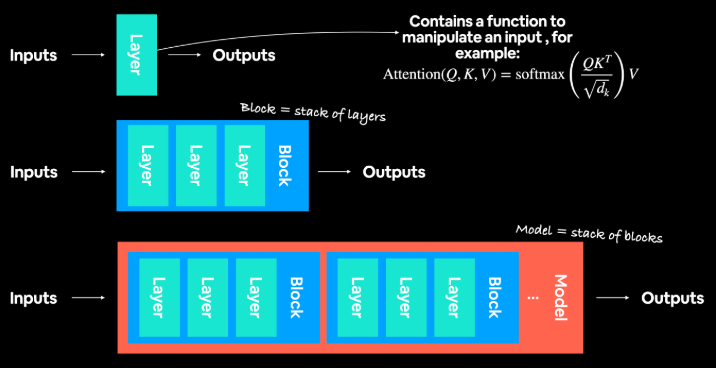

## 3.1 Inputs and ouputs and layers and blocks

>ViT is a deep learning nerual network  architecture

>And an neural netwwork architecutre generally comprised of **layers**

>And a collection of layers is often referred to as **block**

>Stacking many blocks together is what gives us the whole architecture.

A **layer** take an input(sa an image tensor), performs some kind of function on it(e.g `forward()` method) and then returns an output

So if a **single layer** takes an input and gives an output, then  collections of layers or a **block** also takes an input and gives output.

TLDR:
  * **Layers** - takes an inpt, perforsm a function on it, returns an ouput
  * **Block** - a collection of layers, takes an nptm performs a series of functions on it, returns an output
  * **Architecture**(or model) - a collection of blocks, takes an input, performs a series of functions on it, returns an output

The ideology is what we're going to be using to replicated the ViT paper.

### Figure 1:
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

  * Embedding = learneable rerpresentation (start witht random numbers and improved over time)






### Four equations:
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

#### **Section 3.1: Describe the various equations**

>
**Equation 1:**
> An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

|
**Equation 1**
> Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

  In Pseudocode:
  ```python
  Equation 1:
  x_input = [class_token, image_path_1, image_path_2, ... , image_path_N]+ [class_token_pos, image_patch_1_pos, image_path_2_pos, ..., image_path_N_pos]
  ```

**Equation 4**
> Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.
  * MLP: Multilayer preceptron
  * MLP = one hidden layer at training time
  * MLP = single linear layer at fine-tuning time

  In Pseudocode:
  ```python
  # Equation 4:
  y = MLP(LN_layer(x_output_MLP_block)
  ```

**Equation 2 and equation 3**
>The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

  In Pseudocode:
  ```python
  # Equation 2:
  x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
  ```
  ```python
  # Equation 3:
  x_output_MSA_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```



### table 1:
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)

* ViT-Base, ViT0Large and ViT-HUge are all different sizes of the same model architecutre
* ViT-L/16 mean ViT large model with 16 heads
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size through out the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the numbers of multi-head self-attention


## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers  = input -> function -> output

* What is the input shape?

  Input shape: (224, 224, 3) -> single image -> (height, width, color_channel)

* What is the output shape?



**Equation 1:**
> An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

|
**Equation 1**
> Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

  In Pseudocode:
  ```python
  Equation 1:
  x_input = [class_token, image_path_1, image_path_2, ... , image_path_N]+ [class_token_pos, image_patch_1_pos, image_path_2_pos, ..., image_path_N_pos]
  ```


* Input image: $H×{W}×{C}$ (height x width x color channels)
* Output image : ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color-channels
* P = patch size
* N = number of patches = $H×W÷P^{2}$
* D = constant laten vector size = embedding dimension( see table 1)

In [ ]:
# Create example value
height = 224
width = 224
color_channels = 3
path_size = 16

# Caculated the number of patches
number_of_patches = (height * width) / (path_size * path_size)
number_of_patches

196.0

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
print(f"Input shape: {embedding_layer_input_shape}")

# Output shape
embedding_layer_output_shape = number_of_patches ,(path_size * path_size * color_channels)
print(f"Output shape: {embedding_layer_output_shape}")

Input shape: (224, 224, 3)
Output shape: (196.0, 768)


## 4.2 Turn a single image into patches


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

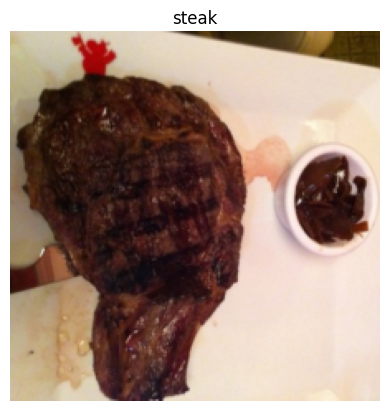

In [ ]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
image.shape

torch.Size([3, 224, 224])

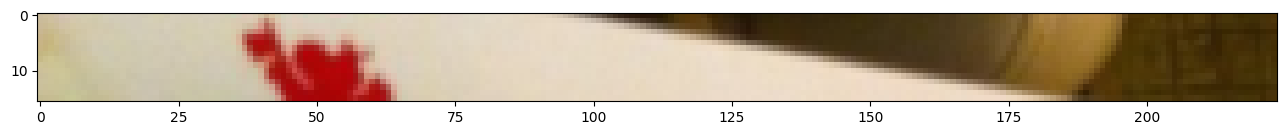

In [ ]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convrt image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per rows: 14.0
 Patch size: 16 pixels x 16 pixels


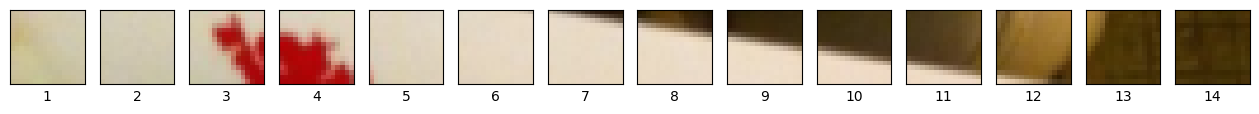

In [ ]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per rows: {num_patches}\n Patch size: {patch_size} pixels x {patch_size} pixels")
# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


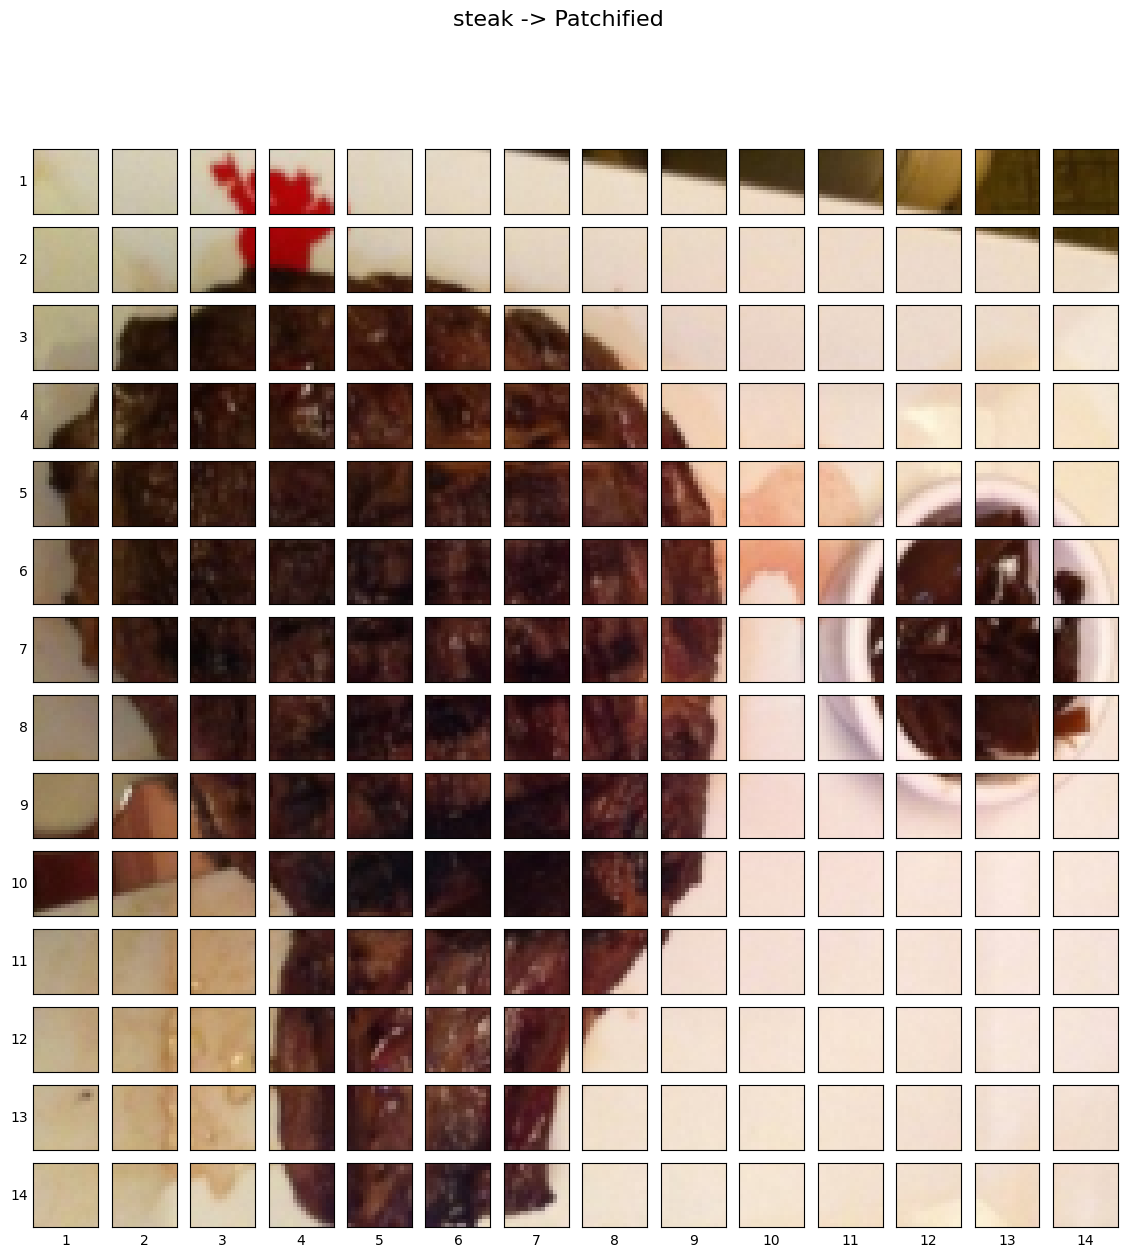

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height :patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

## 4.3 Creating images patches and turning them into patch embeddings

Prehaps we could create the images patches and image patch embeddings in a single step using `torch.nn.Conv2d` and setting the kernal size into `patch_size`

In [ ]:
# Create cov2d layer to turn images into patches of learnable features map(embeddings)

from torch import nn
# Set the patch size
patch_size=16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images,
                   out_channels=768, # hidden D size of table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

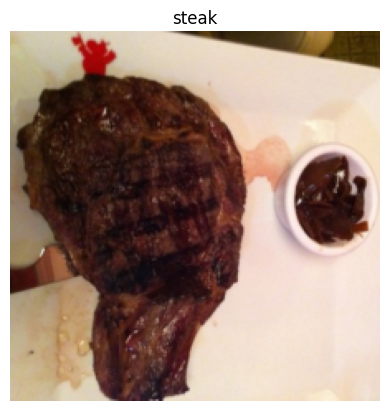

In [ ]:
# View a single images
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# Pass the image thourhg the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # Add batch dimension -> (batch_size, C, H, W)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we're passed a single image to our `conv2d` layer, its shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random covolutional features map from idexes: [461, 428, 339, 61, 441]


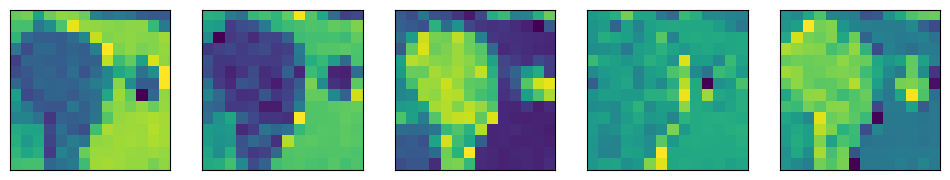

In [ ]:
# plot random convoutional features map (embeddings)
import random
randome_indexs = random.sample(range(0, 758), k=5)
print(f"Showing random covolutional features map from idexes: {randome_indexs}")

# Create plot
fig, axs =plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random images features map
for i, idx in enumerate(randome_indexs):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:

# Get a single features map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.2748, -0.3009, -0.2218, -0.2507, -0.3092, -0.3289, -0.3192,
           -0.1188, -0.0816, -0.1792, -0.1141, -0.0385, -0.0309, -0.0259],
          [-0.2317, -0.2862, -0.3002,  0.1149, -0.3173, -0.3125, -0.3070,
           -0.3265, -0.3211, -0.3228, -0.3215, -0.3489, -0.2343, -0.1335],
          [-0.2276, -0.1323, -0.0810, -0.0493,  0.0009, -0.0148, -0.0708,
           -0.1635, -0.3162, -0.3260, -0.3181, -0.3304, -0.3429, -0.3298],
          [-0.3112, -0.0609, -0.0369, -0.0303, -0.0568, -0.0625, -0.0673,
            0.0021, -0.1337, -0.3233, -0.3274, -0.3128, -0.3035, -0.3289],
          [-0.1436, -0.0494, -0.0510, -0.0236, -0.0326, -0.0503, -0.0562,
           -0.0651, -0.1582, -0.2840, -0.2982, -0.4404, -0.3165, -0.3375],
          [-0.1820, -0.0408, -0.0419, -0.0388, -0.0470, -0.0062, -0.0604,
           -0.1158, -0.0541, -0.1652, -0.0489, -0.0922,  0.0466, -0.0918],
          [-0.1529, -0.0475, -0.0455, -0.0378, -0.0072, -0.0109, -0.0237,
           -0.0992, -0.0798, -0.

## 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a series of convolutional feature maps (patch embeddings) that we want to flatten into sequence of patch embeddings to satisfy the input criteria of the ViT Tranformer Encoder.

In [ ]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want(batch_size, embedding_dim, number_of_patches)

In [ ]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

In [ ]:
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image shape after passing through conv2d: torch.Size([1, 768, 14, 14])
Image shape after flattening: torch.Size([1, 768, 196])


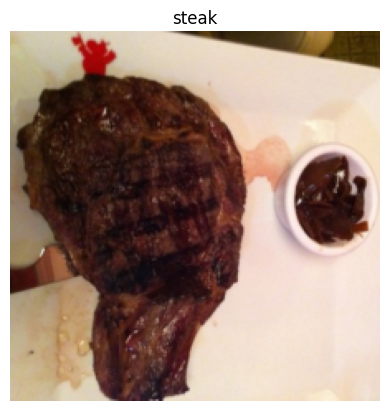

In [ ]:
# Put everything together

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into features map
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image shape after passing through conv2d: {image_out_of_conv.shape}")
#Flatten the feature map
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Image shape after flattening: {image_out_of_conv_flattened.shape}")

In [ ]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened.shape} -> (batch_size, number_of_patches, embedding_dim)")

torch.Size([1, 768, 196]) -> (batch_size, number_of_patches, embedding_dim)


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

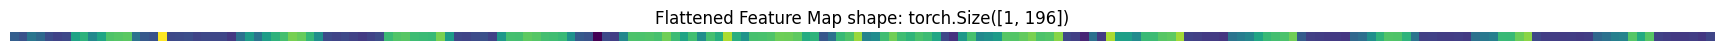

In [ ]:
# Get a single flattened feature map
single_flattended_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

#plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattended_feature_map.detach().numpy())
plt.title(f"Flattened Feature Map shape: {single_flattended_feature_map.shape}")
plt.axis(False)

### 4.5 Turning ViT patch embedding layer into a PyTorch module

This module can do a few things:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimensions, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Convo2d()`
4. Create a layer to fatten the feature maps of the output of the layer in 3.
5. Define a `foward()` that defines the forward computation (e.g pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required ouput shape of the patch embedding.



In [ ]:
# 1. Create a class call PatchEmbedding
import torch
from torch import nn
class PatchEmbedding(nn.Module):
  # 2.Initialize hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # data get from table 1 ViT-Base
    super().__init__()
    # 3. Create a layer to turn an image into embedding patches using nn.Convo2d()
    self.patcher = nn.Conv2d(in_channels=3,
                             out_channels=768,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    # 4. Create a layer to flatten the features map of the output of the layer in # 3.
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    # 5. define a forward method for foward computaion
  def forward(self, x):
    # Create assertion to check that inputs are the ccorrect shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flatten = self.flatten(x_patched)
    # 6. make sure the output shape in the right order(patch_size, number_of_patches, embedding_dimension)
    return x_flatten.permute(0, 2, 1)



In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embebindg layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patched_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patched_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


## 4.6 Create the class token embedding

> Want to: Prepend a learnable class token to the start of the patch embedding

In [ ]:
patched_embedded_image

tensor([[[-0.8056,  0.2118, -0.2084,  ...,  0.5811, -0.3635,  0.2901],
         [-0.8218,  0.2093, -0.2076,  ...,  0.6080, -0.3897,  0.2921],
         [-0.4786,  0.1075, -0.0935,  ...,  0.4182, -0.5030,  0.4069],
         ...,
         [-0.9422,  0.2269, -0.2299,  ...,  0.7027, -0.4416,  0.3424],
         [-0.9361,  0.2129, -0.2309,  ...,  0.6656, -0.4430,  0.3632],
         [-0.9219,  0.2208, -0.2491,  ...,  0.6786, -0.4301,  0.3366]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# Get the batch size and ebmedding dimension
batch_size = patched_embedded_image.shape[0]
embedding_dimension = patched_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [ ]:
# Create a class token eembedding as a learnable parameter that shares the same size as the embedding dimension (D)

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                            requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
# add the class token embedding to the front of the patch embedding
patched_embedded_image_with_class_token = torch.cat((class_token, patched_embedded_image),
                                                     dim=1) # number_of_patches_dimension
print(patched_embedded_image_with_class_token)
print(f"The shape of class prepended shape: {patched_embedded_image_with_class_token.shape} -> (batch_size, class_token + patched_embeded_image, embedding dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8056,  0.2118, -0.2084,  ...,  0.5811, -0.3635,  0.2901],
         [-0.8218,  0.2093, -0.2076,  ...,  0.6080, -0.3897,  0.2921],
         ...,
         [-0.9422,  0.2269, -0.2299,  ...,  0.7027, -0.4416,  0.3424],
         [-0.9361,  0.2129, -0.2309,  ...,  0.6656, -0.4430,  0.3632],
         [-0.9219,  0.2208, -0.2491,  ...,  0.6786, -0.4301,  0.3366]]],
       grad_fn=<CatBackward0>)
The shape of class prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + patched_embeded_image, embedding dim)


### 4.7 Creating the position embedding

Want to: createa a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings

Or $\mathbf{E}_{\text {pos }}$ from equation 1 where $E$ stands for "embedding".

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patched_embedded_image_with_class_token, patched_embedded_image_with_class_token.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.8056,  0.2118, -0.2084,  ...,  0.5811, -0.3635,  0.2901],
          [-0.8218,  0.2093, -0.2076,  ...,  0.6080, -0.3897,  0.2921],
          ...,
          [-0.9422,  0.2269, -0.2299,  ...,  0.7027, -0.4416,  0.3424],
          [-0.9361,  0.2129, -0.2309,  ...,  0.6656, -0.4430,  0.3632],
          [-0.9219,  0.2208, -0.2491,  ...,  0.6786, -0.4301,  0.3366]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
from pickle import TRUE
# Caculated N (number_of_patches)
number_of_patches =  int(height * width / (patch_size * patch_size))

# Get the embedding dimension
embedding_dimension = patched_embedded_image_with_class_token.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# ADd the position embedding to the patch embedding token
patched_embedded_image_with_class_token_position = patched_embedded_image_with_class_token + position_embedding
patched_embedded_image_with_class_token_position, patched_embedded_image_with_class_token_position.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.1944, 1.2118, 0.7916,  ..., 1.5811, 0.6365, 1.2901],
          [0.1782, 1.2093, 0.7924,  ..., 1.6080, 0.6103, 1.2921],
          ...,
          [0.0578, 1.2269, 0.7701,  ..., 1.7027, 0.5584, 1.3424],
          [0.0639, 1.2129, 0.7691,  ..., 1.6656, 0.5570, 1.3632],
          [0.0781, 1.2208, 0.7509,  ..., 1.6786, 0.5699, 1.3366]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

## 4.8 Putitng everything together: From image to embedding
Equation 1:
> $$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

Let's now put everything together in a single code cell and go from input image ($\mathbf{x}$) to output embedding ($\mathbf{z}_0$).

We can do it by:
1. Set the patch size to 16( we will use ViT-Base which patch size is 16)
2. Getting a single images heights and width
3. Adding one batch dimension to a single images so it's comaptiable `PatchEmbedding` layer.
4. Create `PatchEmbedding` layers and set it with `patch_size=16` and `embedding_size=768`.
5. Passing `PatchEmbedding` layer in 4 to create a sequcens of patch embedding
6. Create a class token embdding just like section 4.6
7. Prepending the class token embedding created in step 5
8. Create a position embedding in liek section 4.7
9. Adding the position embedding to the class token and patch embedding created in step 7.

In [ ]:
set_seeds()

#1. Set the patch size 16
patch_size = 16
#2. Getting a single images heights and width
print(f"Original image shape: {image.shape}")
height, width = image.shape[1], image.shape[2]
#3. Adding one batch dimension ot a single images to it's compatible with `PatchEmbedding`
x = image.unsqueeze(0)
print(f"Image shape after adding batch dimension: {x.shape}")
#4. Create PatchEmbedding
patchify = PatchEmbedding(in_channels=3,
                          patch_size=patch_size,
                          embedding_dim=768)

# 5. Pass image throught patch embedding layre
patch_embedding = patchify(x)
print(f"Patched embedding image shape: {patch_embedding.shape}")
# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
# 7. Prepending the class token embedding created in step 5
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patched embedding image with class token shape: {patch_embedding_with_class_token.shape}")
# 8. Create a position embedding
number_of_patches = int(height * width / (patch_size * patch_size))
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)
# 9. Adding the position embedding to the class token and patch embedding with
patch_embedding_with_class_token_position = patch_embedding_with_class_token + position_embedding
print(f"Patched embedding image with class token and position embedding shape: {patch_embedding_with_class_token_position.shape}")

Original image shape: torch.Size([3, 224, 224])
Image shape after adding batch dimension: torch.Size([1, 3, 224, 224])
Patched embedding image shape: torch.Size([1, 196, 768])
Patched embedding image with class token shape: torch.Size([1, 197, 768])
Patched embedding image with class token and position embedding shape: torch.Size([1, 197, 768])


This is the break down of the code we just did:

image.png





## 5. Equation 2: Multi-Head Attention(MSA block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded images patches, which patch significantly relates to another patch
  * We want our neural network (ViT) to learn this relationship/representation
  * LayerNorm = Layer normalization is a technique to normalzie the distributions of intermediate layers. It enables smoother gradients, faster training, and better generationlization accuracy.
    * Normalization = make everything have the same mean and same standard deviation (`torch.nn.MultiheadAttention()`)
   * In Pytorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension (`torch.nn.LayerNorm()`)
      * When we normalize along the embedding dimension, it's like making all of the stiar in a staircase in the same size

In [ ]:
class MSABlock(nn.Module):
  def __init__(self,
               embed_dim:int=768,
               n_heads:int=12,
               attn_dropout:int=0):
    super().__init__()
    # Create the norm layer(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
    # Creating multiple attention layer (MSA layer)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim,
                                                num_heads=n_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                         need_weights=False)
    return attn_output

 Passing through the variable we just created


In [ ]:
# Create an instane of MSAblock
multihead_self_atatention_block = MSABlock(embed_dim=768,
                                                     n_heads=12)

# Pass patch and position image embedding through MSAblock
patche_image_through_MSAblock = multihead_self_atatention_block(patch_embedding_with_class_token_position)
print(f"Input shape of MSA block: {patch_embedding_with_class_token_position.shape}")
print(f"Output shape of MSA block: {patche_image_through_MSAblock.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


Overall this is what we have done

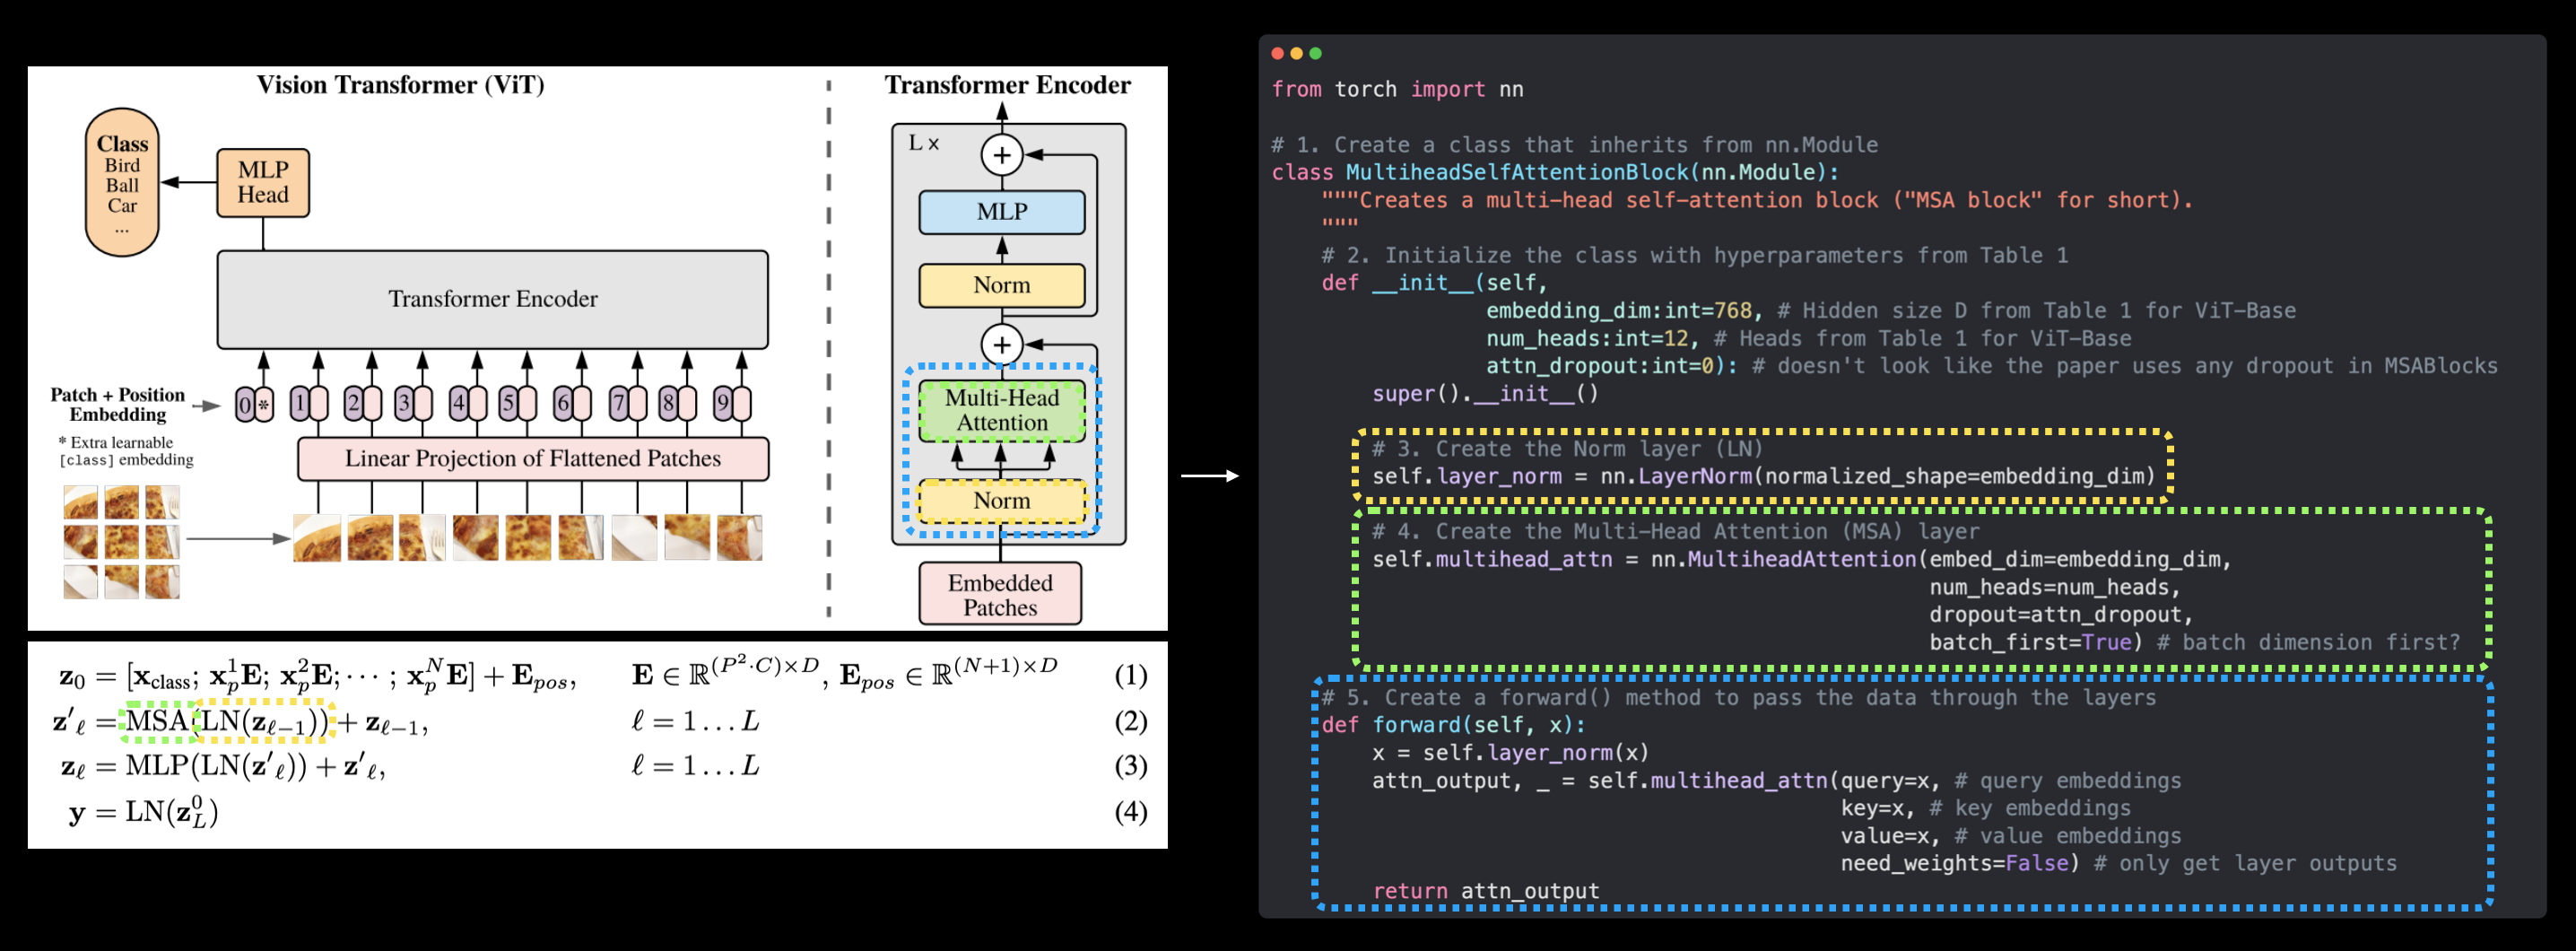

# 5.3 Replicating Equation 3: Multilayer Preceptron (MLP)

Refresh:
* MLP: Multilayer Preceptron
* LN: Layer Normalization

On equation 3, we'll refer as the "MLP block" of the tranformer encoder
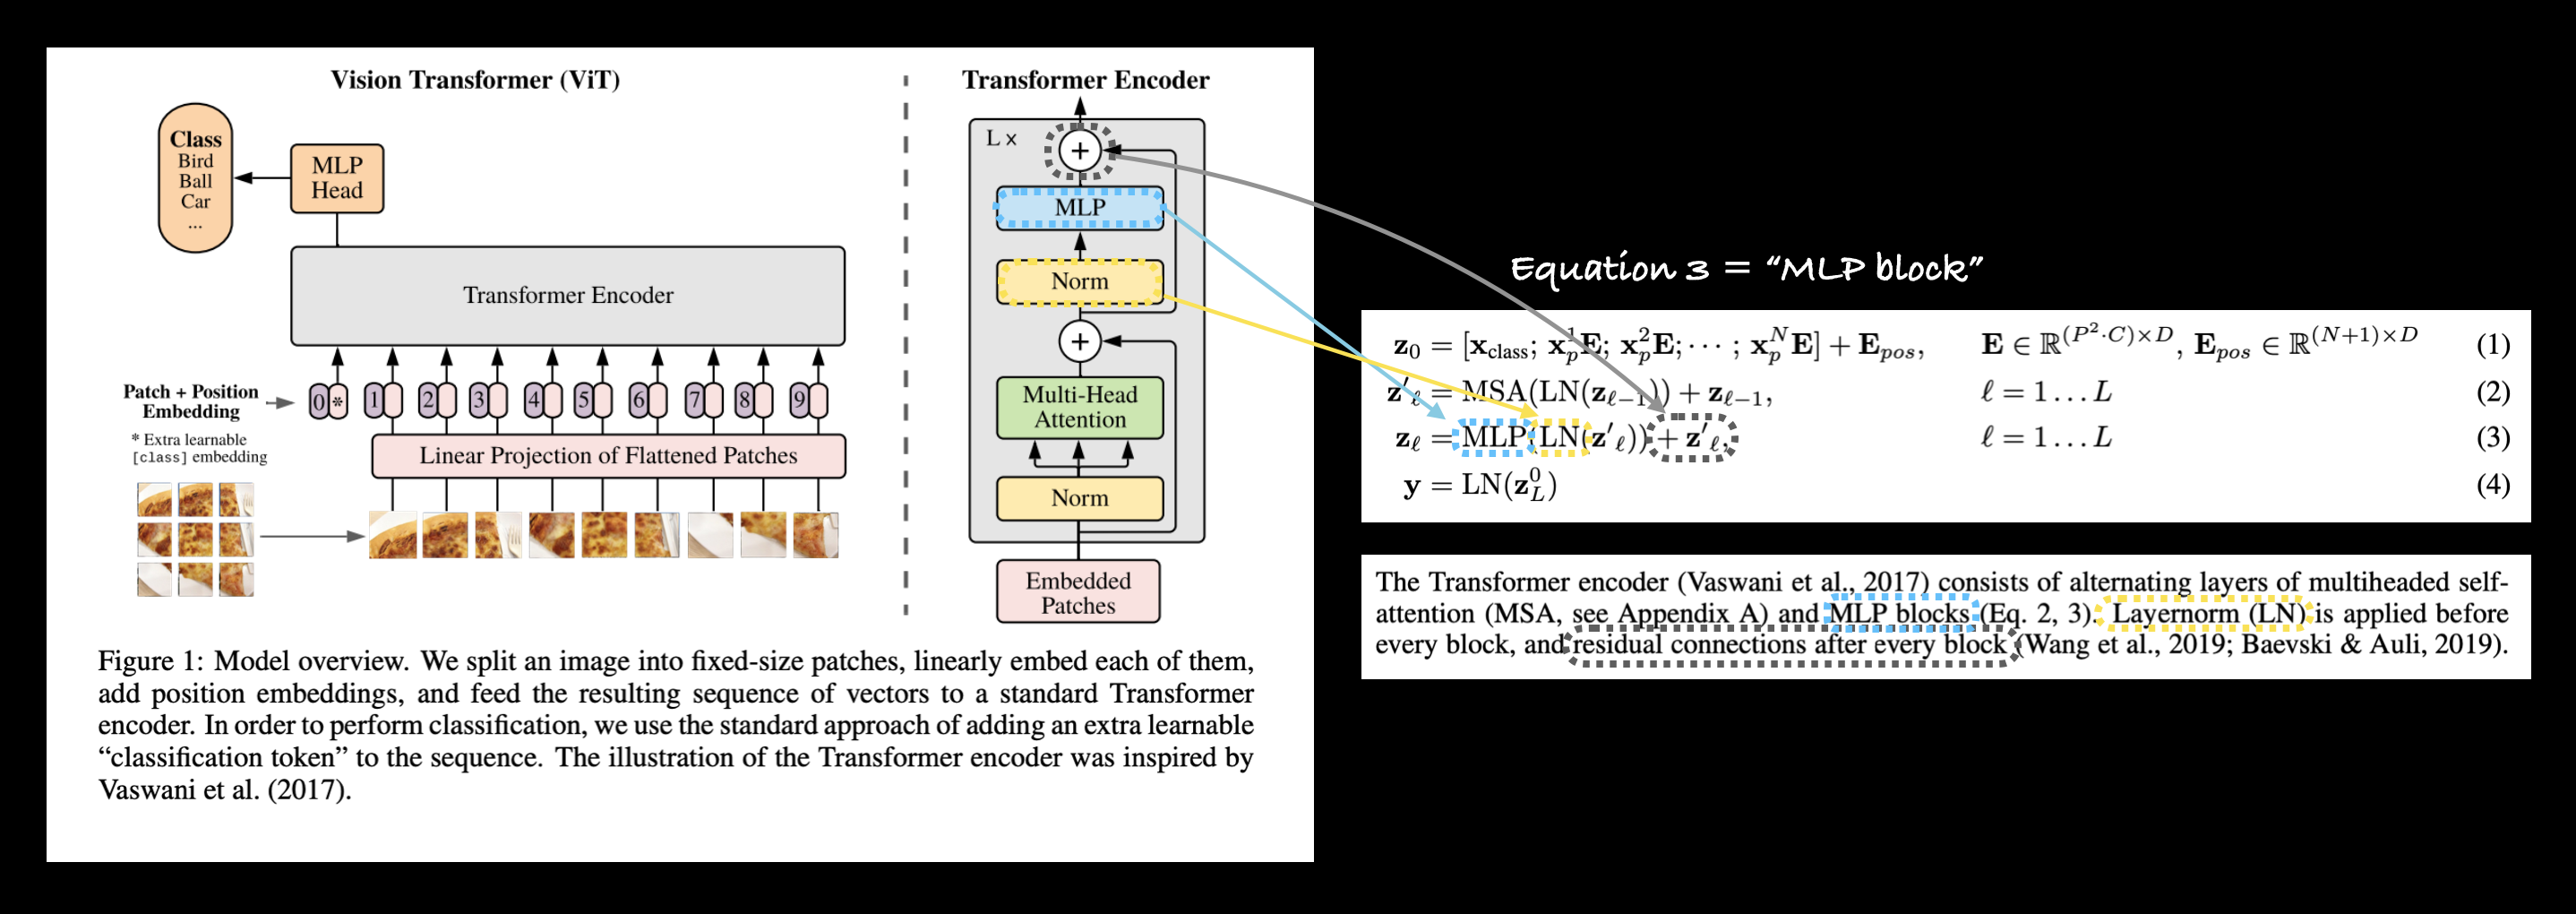

# 6.1: The MLP layer(s)

The term MP is quite borad as it can be refer to almost any combination of multiple layers, but generally, follows the pattern of:

```
linear layer - > non-linaer layer -> linear layer -> nonlinear layer
```

In the case of ViT paper, the MLP structure is defined as:
> The MLP contains two layers with a GELU non-linearity

What that mean is, where "two layers" refers to linearlayers(`torch.nn.Linear()` in PyTorch) and "GELU non-linearirty" is the GELU(Gaussian Error Linear Unit) non-linear activation function (`torch.nn.GELU()`) in PyTorch

> NOTE: A linear layer(`torch.nn.Linear()` can sometimes also be referred to be as a "dense layer" or "feedforward layer"

From the book, there is a sneaky details about the MLP blocks doesn't appear until Appenddix B.1(Training)

> Table 3 summarizes our training setups for our different models. ... Dropout, when used, is applied **after every dense layer except for the qkv-projections and driectly after adding positional- to patch embeddings.**

What this mean is that every linear layeres will come with a dropout layer(`torch.nn.Dropout())

This value can be found on Table 3 of the ViTbase paper( `dropout=0.1`)

So in conclusion, the strucutre of our MLP blocks would be:

```
layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout
```

## 6.2 replicating equation 3 with layers

Let's put everything together, to do it we'll:
1. Create a class called `MLPBlock`, that inherits from `torch.nn.Module`
2. Initialzie the class with hyperaparameters from Table 1 and Table 3 of the ViT paper
3. Create a layer normalization(LN) layer with `torch.nn.LayerNorm()` with the `normalzied_shape` parameter the same as our emedding dimension( $D$ from table 1)
4. Create a sequential series of MLP layer(s) using `torch.nn.Linear()`, `torch.nn.Dropout()` and `torch.nn.GELU()` with appripriate hyperparameteres values from table 1 and table 3
5. Create a forward() method for our class passing in the inputs through the LN layers an MLP layer(s)

In [ ]:
# 1. Create a class that inherits from `torch.nn.Module`
class MLPBlock(nn.Module):
  # 2. Initialize the class with hyperparametrs from table 1 and table 3 from the paper
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1
               mlp_size:int=3072, # MLP size from table 1
               dropout:float=0.1): # dropout size from table 3
    super().__init__()
    # 3. Create a layer normalization
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    # 4. Crate a multiplayers preceptron(MLP) layer(s)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )
  # 5. Create a forward methiod
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [ ]:
# Check out the instance of MLP block
mlp_block = MLPBlock()

# pass output
patche_image_through_MLPblock = mlp_block(patche_image_through_MSAblock)
print(f"Input shape: {patche_image_through_MSAblock.shape}")
print(f"Output shape: {patche_image_through_MLPblock.shape}")

Input shape: torch.Size([1, 197, 768])
Output shape: torch.Size([1, 197, 768])


So far here is what we have done:

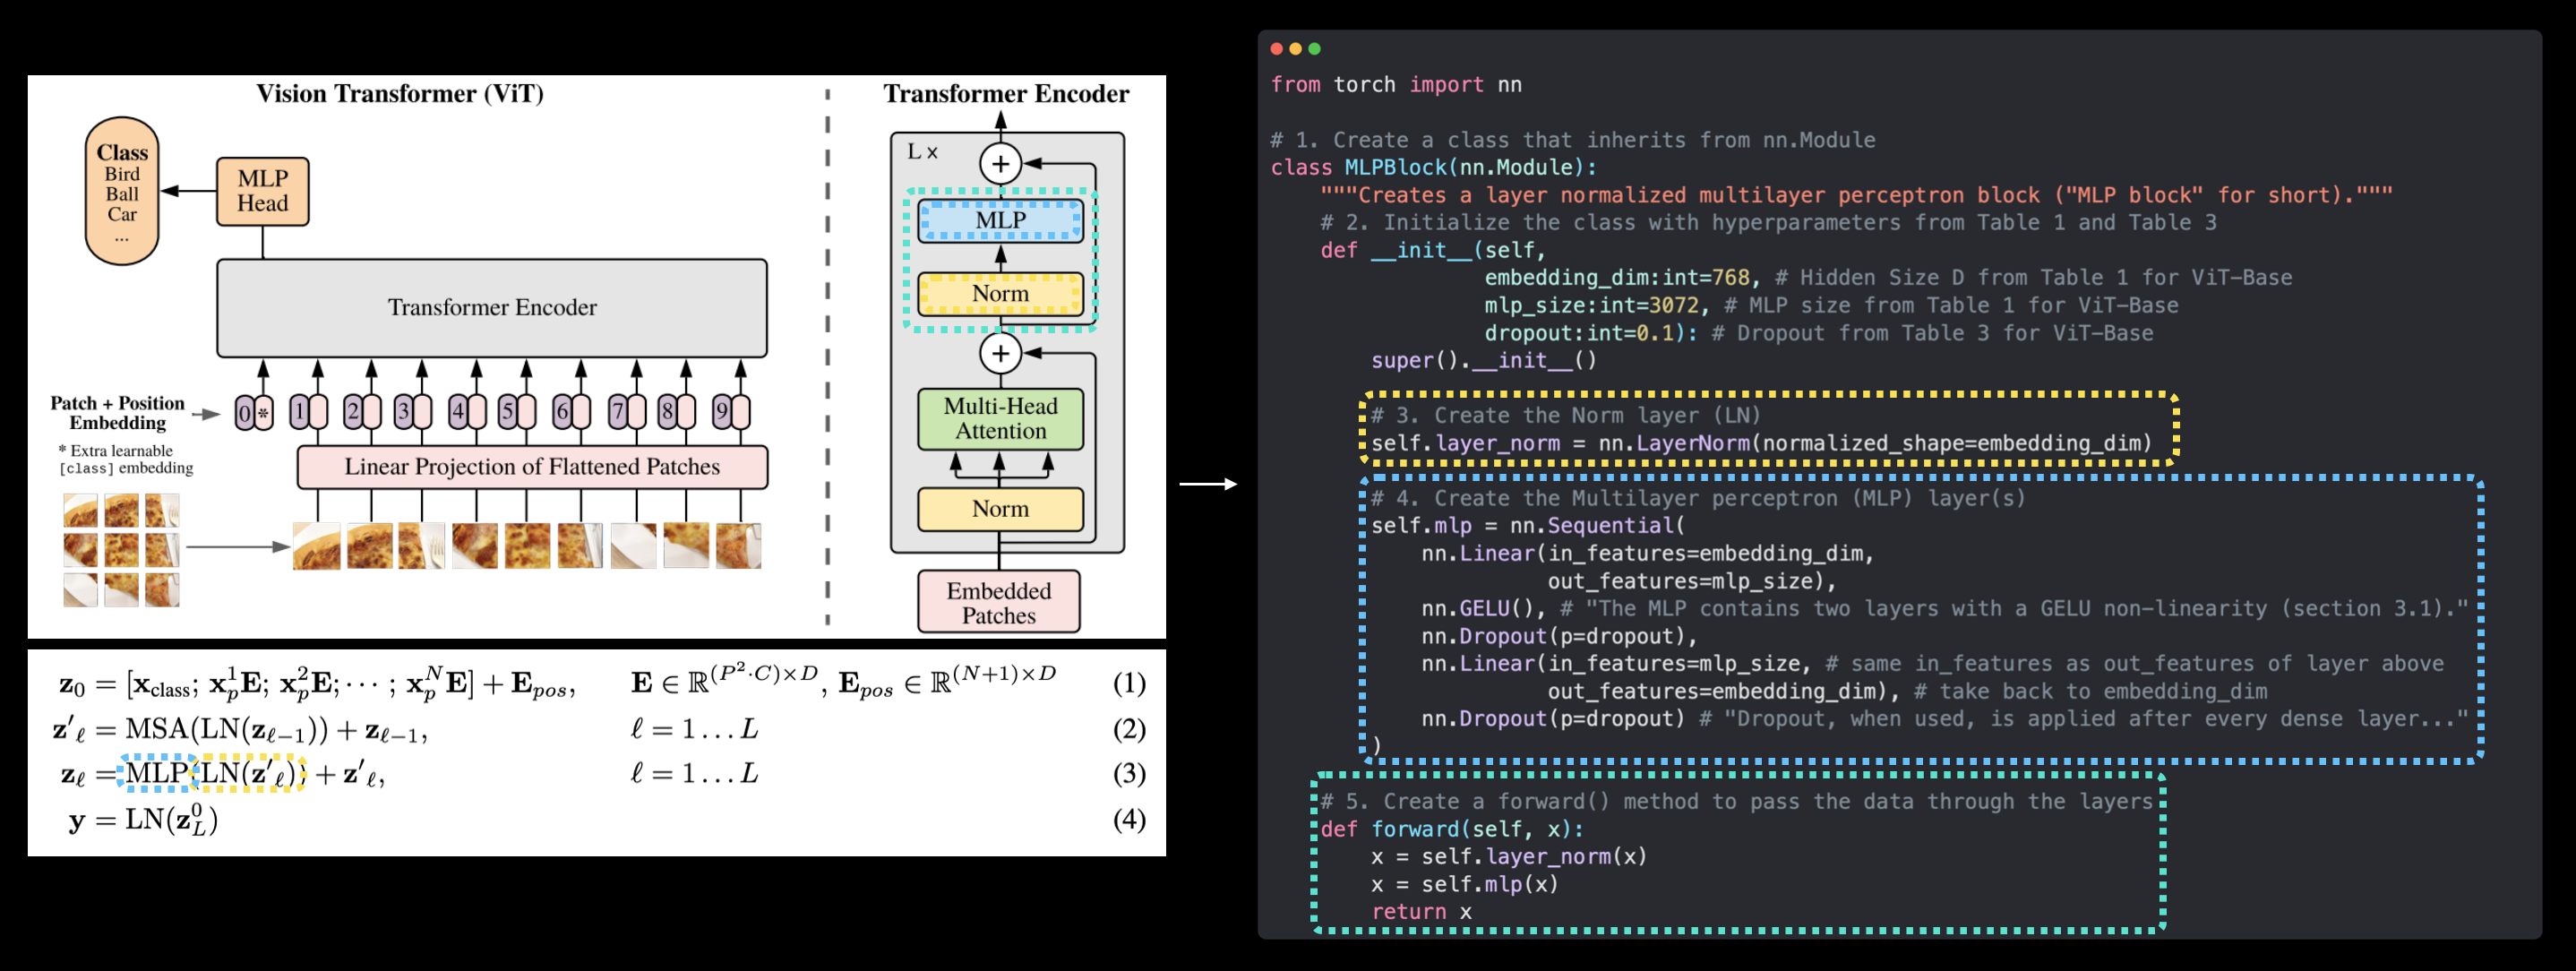


# 7. Create the transformer encoder

This time, we'll stack together our **equation 2** and **equation 3** together and create the Transformer Encoder of the ViT architecture.

* In deep learning, an "encoder" or "auto encoder" generally rfers to a stack of layers that "encodes" an input(means: turn it into some form of numerical representation)

In our case, the Transformer Encoder will encode our patched image embedding into a learn representation using a seies of laternating layers of MSA blocks and MLP blocks

---
*We have MSA blocks and MLP blocks, so how about residual connections?*

* [Residual connections](https://towardsdatascience.com/what-is-residual-connection-efb07cab0d55/) (also called skip connections) which is a simple yet very effective technique to make training deep neural networks easier by adding a layer(s) input to its subsequent output

Where the subsequence output might be one or more layers later

* In the case of ViT architecture, the residual connection means the input of the MSA block is added bcack to the output of te MSA block before it passes through the MLP block
* Same thing happens with the MLP block before it goes onto next Tranformer Ecoder blocks

In pseudocode:
```
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input]
```

## 7.1 Creating a transformer encoder by combining our custom made layer

To do that we'll:
1. Create a class called TransformerEncoderBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our MultiheadSelfAttentionBlock from section 5.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropriate parameters.
5. Create a forward() method for our TransformerEncoderBlock class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).




In [ ]:
# 1. Create a class that inherit from nn.Module
class TransformerEncoderBlock(nn.Module):
  # 2. initilize the class with hyperparameters from table 1 and table 3
  def __init__(self,
               embed_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               mlp_dropout:float=0.1,
               attn_dropout:float=0):
    super().__init__()
    # 3.Create MSa block (equation 2)
    self.msa_block = MSABlock(embed_dim, num_heads, attn_dropout)
    # 4. Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embed_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
    # 5. Create a fowward method
  def forward(self, x):
    #6. Create a residual connection for MSa block
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

What we done above is:
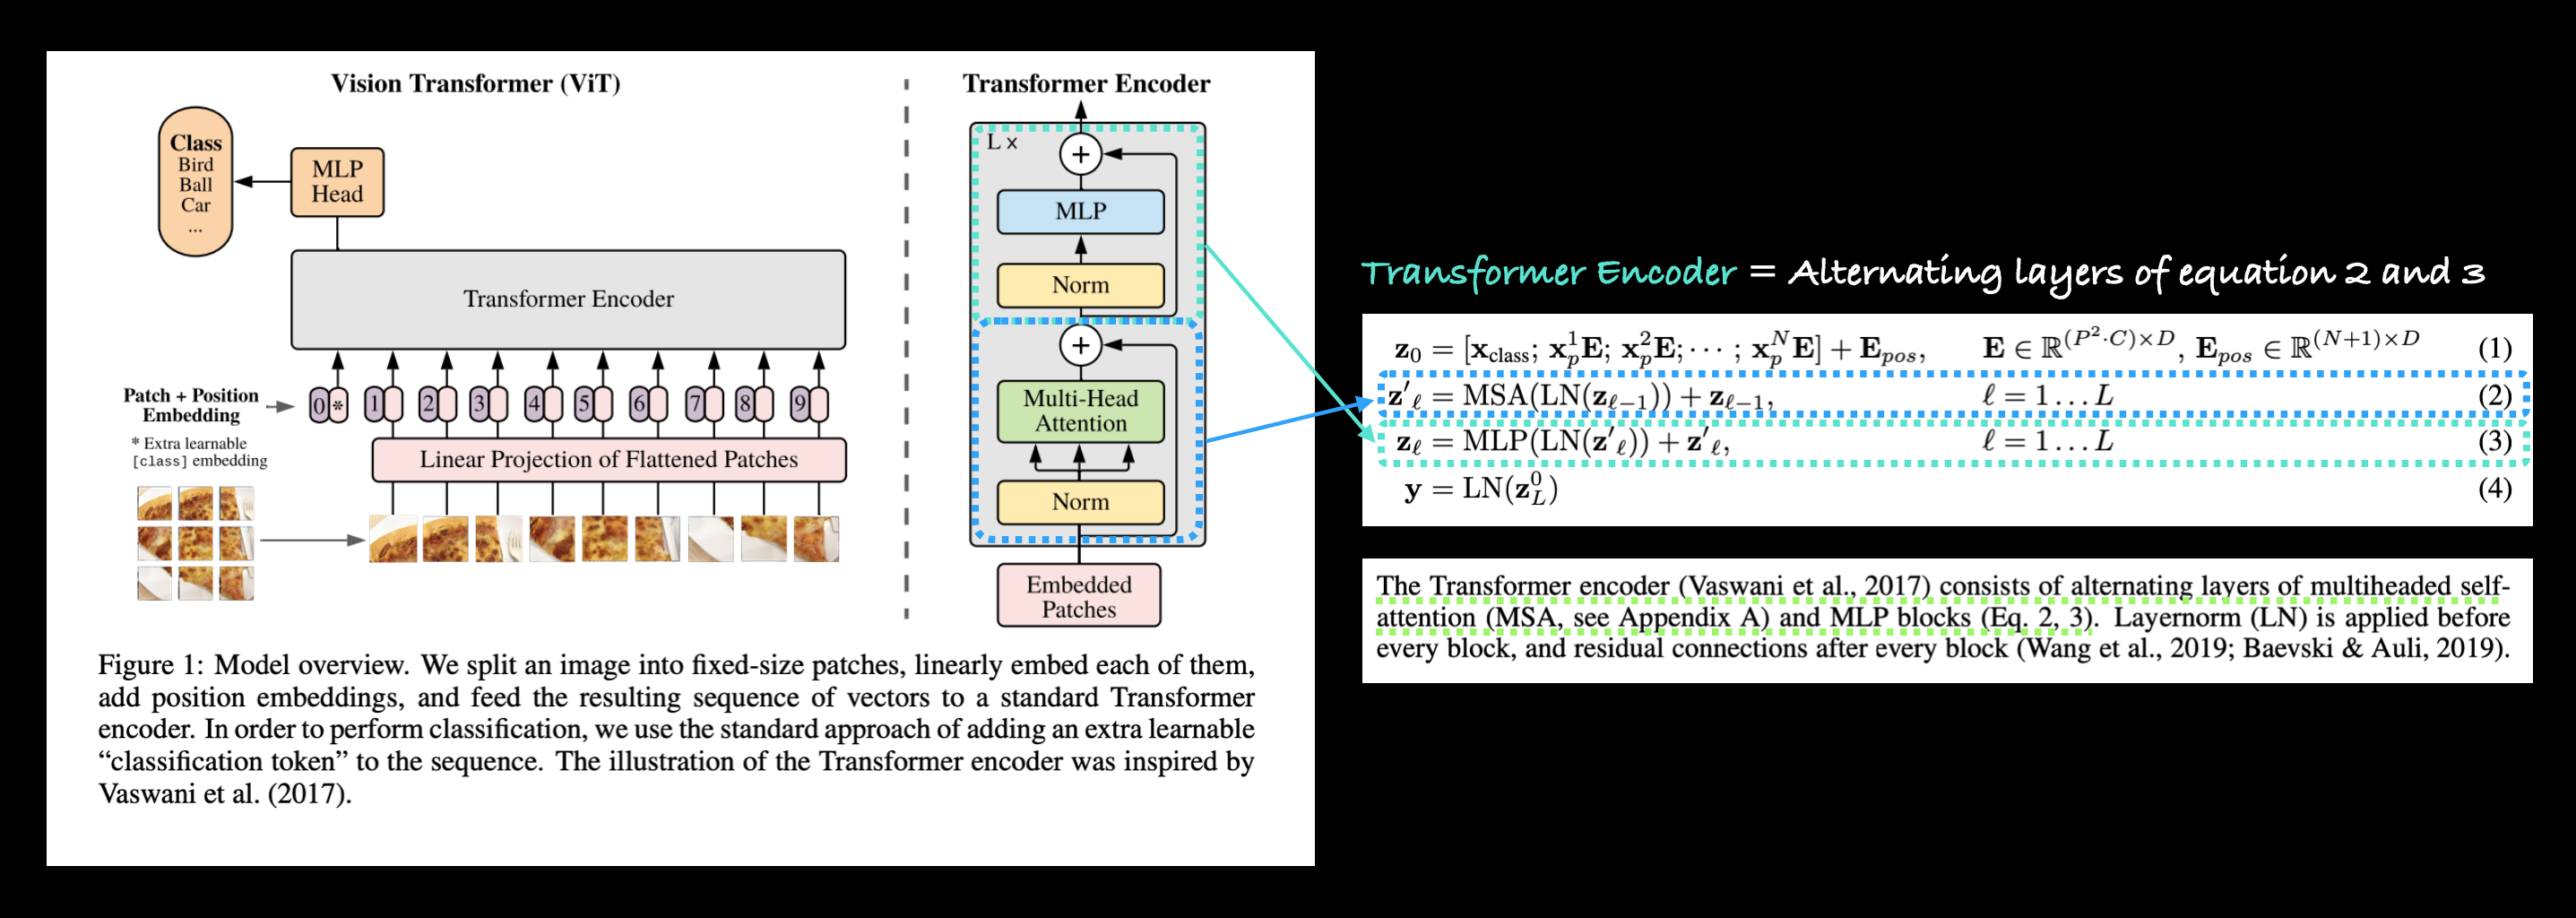

Here is the mapping for the ViT Tranformer Encoder to code
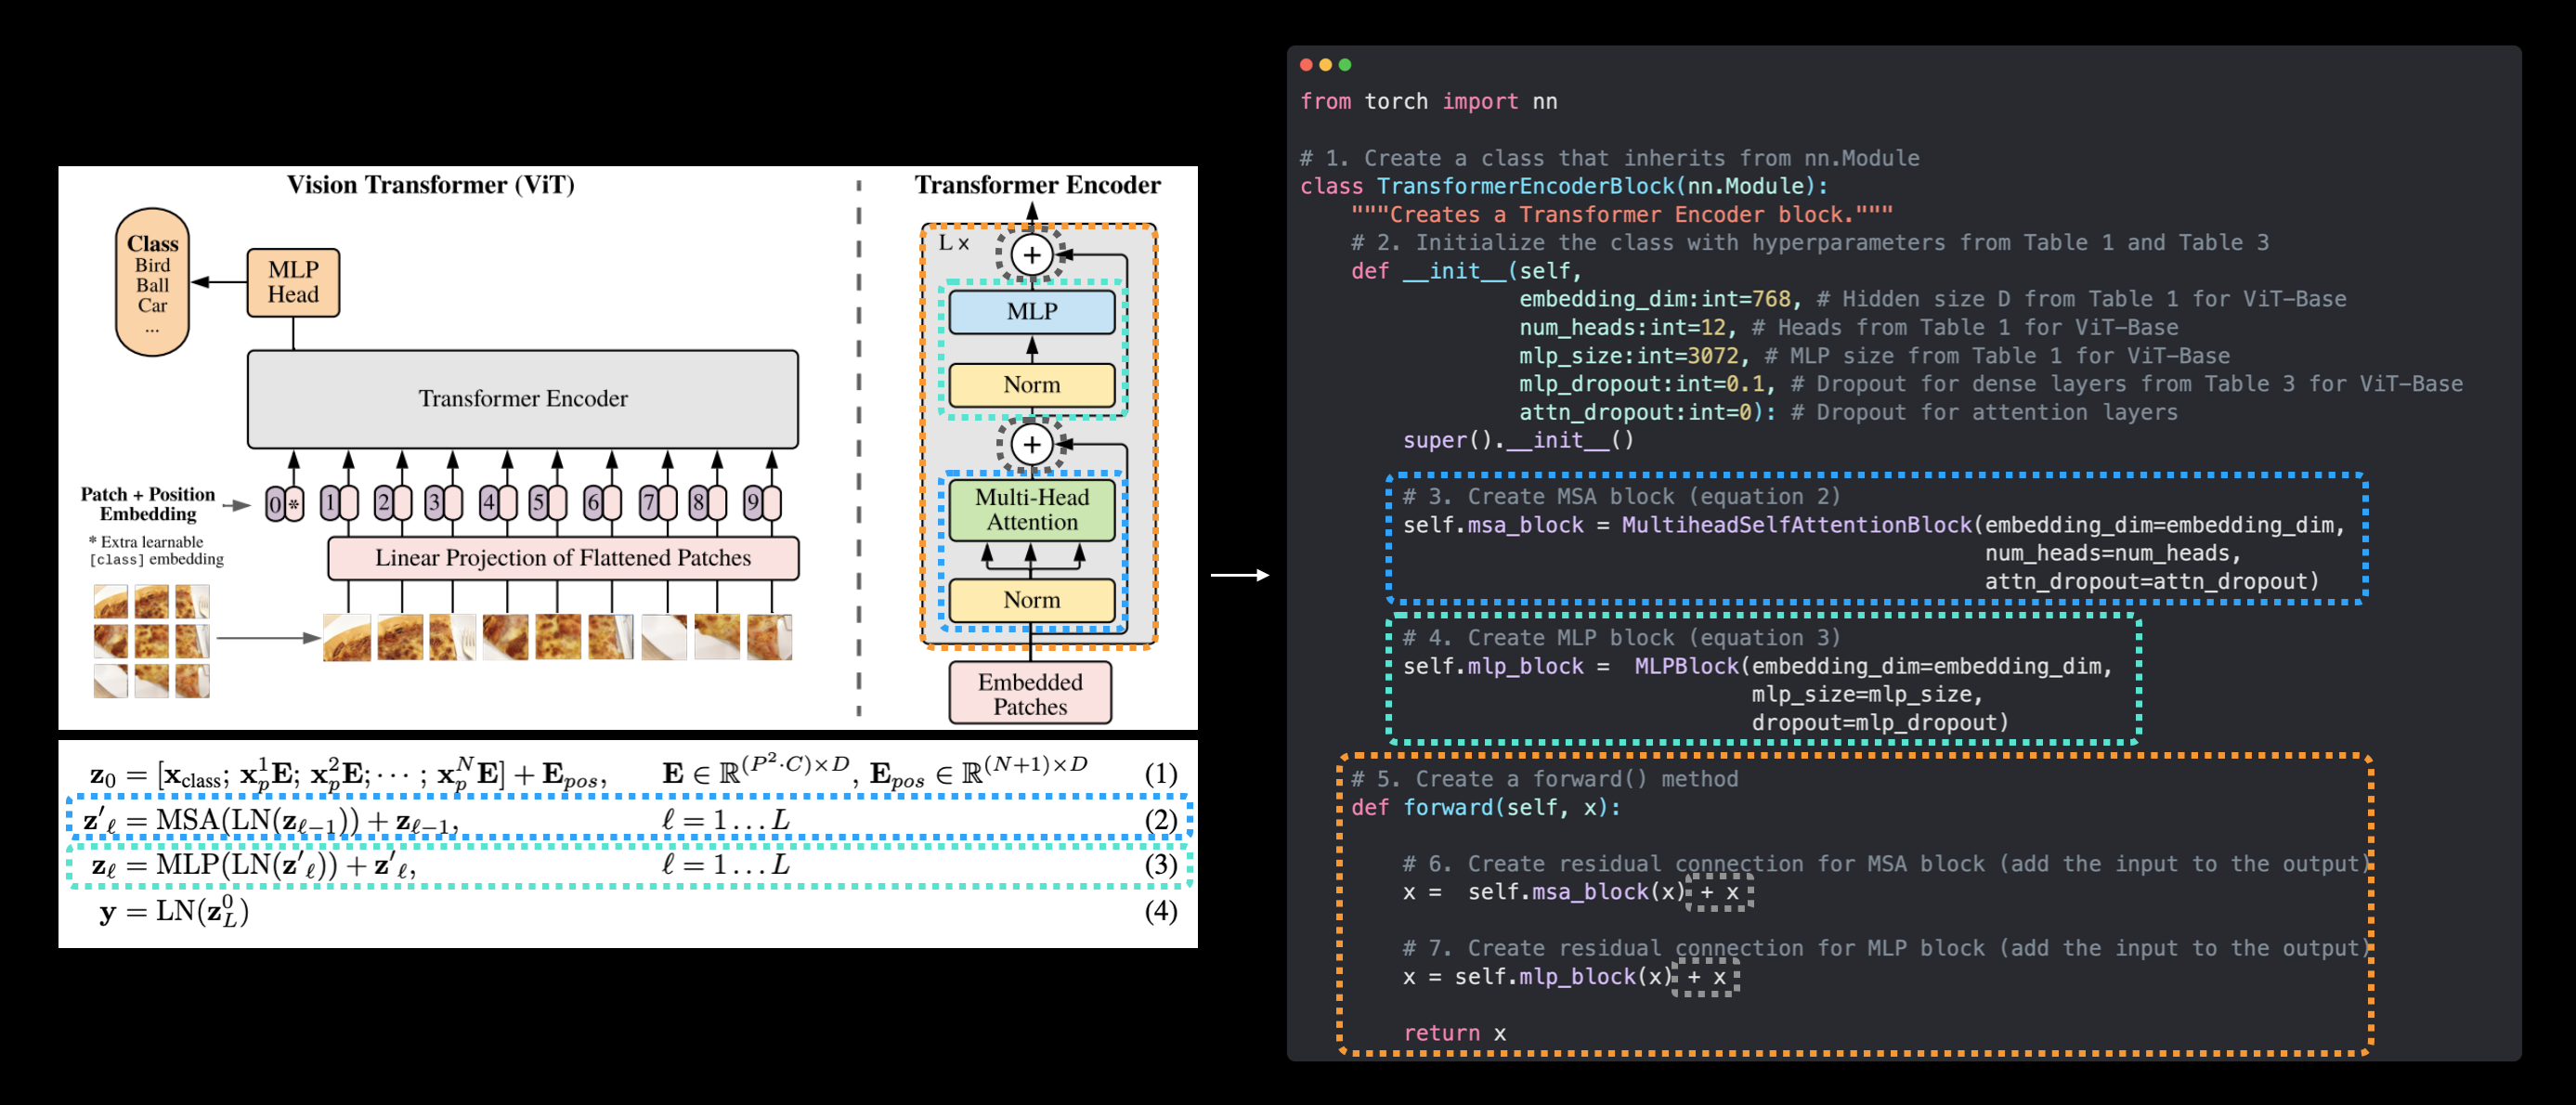


Now we use `torchinfo` to get summary


In [ ]:
# Create an instance of TransfomerEncoderblock
tranformer_encoder_block = TransformerEncoderBlock()

# print out an input and output
summary(model=tranformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        --                   True
├─MSABlock (msa_block)                             [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        --                   True
│    │    └─Linear (0)                             [1, 197, 768]        2,362,368            True
│    │    └─GELU (1)                               [1, 197, 3072]       --                   --
│    │    └─Dropo

## 7.2: Creating a transformer Encoder with Pytorch Tranformer layers

What have done so far is built the components of and the Transformer Encoder layers itself.

But since Pytorch is awlays involving, now we already has a in-built [Transformer layers as part of `torch.nn`](https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)

Now instead of coding it ourself, we ca recreate the `TransformerEncoderBlock` we just did by using `torch.nn.TransformerEncoderLayer()` and setting the same hyperparameters as above

In [ ]:
# Create the same instance but now with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from table 1 of ViT-base paper
                                                             nhead=8, # Heads from table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size fro table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from table 3 for ViT-Base
                                                             activation="gelu", # GELU for non-linear activation
                                                             batch_first=True, # Do our batch come first? Yes
                                                             norm_first=True) # Normalize first or after MSA/MLP layers? First

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       --                   --
├─Linear (linear2)                                 [1, 197, 3072]       2,360,064            True
├─Dropout (dropout2)                               [1, 197, 768]        --                   --
Total params: 7,087,8

So what is the different between coding itself and using the pre-built?

* Less prone to errors: Generally, if a layer makes it into Pytorch standard library, that mean it have been tested and tried to work
* Potentially better performance: Sometime, the speed can be x2 with many common workloads.

# 8. Putting it all together to create ViT module

What we have done so far, is creating ***equation 1 , equation 2, equation 3***  and lastly we only need to created equation 4.

> Equation 4: $$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$


We will be using `torch.nn.LayerNorm()` layer and a `torch.nn.Linear()` layer to convert the 0th index ($\mathbf{z}_{L}^{0}$) of the Transformer Encoder logit outputs to the targetnumber fo classes we have

To do that, we'll also need to stack a number of our `TransformerEncoderBlock` on top of each other by passing a list of them to `torch.nn.Sequential()`



To bring our own implementation of ViT to life, let's:
1. Creatae a class called `ViT` that inherits from `torch.nn.Module`
2. Initialize the class with hyperparamters frm table 1 and table 3 of the ViT paper
3. Make sure the images size is divisiable by the patch size
4. Caculated the number of patches using the formular $N=HW/P^{2}$ where:
  * $H$ is the images height
  * $W$ is the images weights
  * $P$ is the images patch size
5. Create a learnable class emedding token (equation 1: [section 4.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#46-creating-the-class-token-embedding))
6. Create a learble position embedding vector (equation 1: [section 4.7](https://www.learnpytorch.io/08_pytorch_paper_replicating/#47-creating-the-position-embedding))
7. Setup embedding dropout layers as discuessed in Appendix B.1 of ViT paper
8. Create the patch ebmedding layer using `PatchEmbdding` class in [section 4.5](https://www.learnpytorch.io/08_pytorch_paper_replicating/#45-turning-the-vit-patch-embedding-layer-into-a-pytorch-module)
9. Create a series of Transformer Encoder blocks by passing a list of `TranformerEncoderBlock` create in [section 7.1](https://www.learnpytorch.io/08_pytorch_paper_replicating/#71-creating-a-transformer-encoder-by-combining-our-custom-made-layers) to `torch.nn.Sequential()`
10. Create the MLP head for **equation 4** by passing a `torch.nn.LayerNorm()`(LN) layer and a `torch.nn.Linear(out_features=num_classes` layer (where `num_classes` is the number fo classes) linear layer to `torch.nn.Seuqnetial()`
11. Create a `forward()` method that accepts the input
12. Get a batch size of the input(first dimension of he shape)
13. Create th patching embedding using the layer create in equation 1
14. Create the class token embedding using the layer created in **step 5** and expand it acorss the number of batches found in step **11** using `torch.Tensor.expan()`
15. Concatenate the class token embedding create in step **13** to the first dimension of the pach embedding created in step 12 using `torch.cat()
16. Add the position embedding create in step **6** to the patch and class token embedding create in step 14 (equation 1)
17. Pass the patch and position embedding through the dropout in step **7**
18. Pass the patch and position embedding from step 16 throught the stack of Transfoerm Encder layer c reated in step(equation 2 and 3)
19. Pas index 0 of the output of the stack of Transfoerm encoder layers from step 17 through the classifer head created in step **10**(equation 4)
20. Kill myself doing all of this


In [ ]:
# 1. Create a Vit class that inherits from nn.Module
class ViT(nn.Module):
  # 2. Initialize the class hyperparamters from table 1 and table 3 of the vit paper
  def __init__(self,
               img_size=224, # Training resolution found on Table 3 in ViT paper
               in_channels:int=3, # Number of channels in input images
               patch_size:int=16, # The patch size
               num_transformer_layer:int=12, # Katers from table 1 of ViT-Base
               embedding_dim:int=768, #Hidden size D from table 1
               mlp_size:int=3072, # MLP size from table 1
               num_head:int=12, # heads from table 1 for ViT-base
               attn_dropout:float=0, # Dropout for attention projection
               mlp_dropout:float=0.1, # Dropout for dense/MLP layers
               embedding_dropout:float=0.1, # Dropout for patch and position embedding layers
               num_classes:int=1000): # Number of class but can be customize
    super().__init__()
    # 3.Make the image size is divisiable by the patch_size
    assert img_size % patch_size == 0, f"Image size must be divisiable by the patch size."
    # 4. Caculated the number of patches
    self.num_patches = (img_size * img_size // patch_size**2)
    # 5. Crate learble class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
    # 6. Create learnable posiition embedding
    self.position_embedding = nn.Parameter(data=torch.rand(1, 1, embedding_dim),
                                           requires_grad=True)
    #7. Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)
    # 8. Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    # 9. Create tranformer encoder blocks
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim=embedding_dim,
                                                                       mlp_size=mlp_size,
                                                                       num_heads=num_head,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layer)])
    # 10. Create the MLP head
    self.mlp_head = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                  nn.Linear(in_features=embedding_dim,
                                            out_features=num_classes))
  # 11. Create a forward() method
  def forward(self, x):

      # 12. Get batch size
      batch_size = x.shape[0]

      # 13. Create class token embedding and expand it to match the batch size (equation 1)
      class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

      # 14. Create patch embedding (equation 1)
      x = self.patch_embedding(x)

      # 15. Concat class embedding and patch embedding (equation 1)
      x = torch.cat((class_token, x), dim=1)

      # 16. Add position embedding to patch embedding (equation 1)
      x = self.position_embedding + x

      # 17. Run embedding dropout (Appendix B.1)
      x = self.embedding_dropout(x)

      # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
      x = self.transformer_encoder(x)

      # 19. Put 0 index logit through classifier (equation 4)
      x = self.mlp_head(x[:, 0]) # run on each sample in a batch at 0 index

      return x

In [ ]:
# example of creting the class embedding and expanding ove a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768),
                                        requires_grad=True)
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f"Shape of the class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of the class token embedding expanded: {class_token_embedding_expanded.shape}")


Shape of the class token embedding single: torch.Size([1, 1, 768])
Shape of the class token embedding expanded: torch.Size([32, 1, 768])


Notice how the first dimensions get expanded to match the batch size and the other dimensions stay the same (because they're inferred by the `"-1"` dimensions in `.expand(batch_size, -1, 1))`

In [ ]:
set_seeds()

# Create a random tensor with same shape as single image
random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names))
# Pass the random images tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.2509,  0.0755, -0.1098]], grad_fn=<AddmmBackward0>)

## 8.1 Getting a visual summary for the ViT model

Using torchinfo summary we will see the overview input and the output of our model


In [ ]:
summary(model=vit,
         input_size=(1, 3, 224, 224),
         col_names=["input_size","output_size","num_params","trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               1,536                True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9.1 Create an optimizer

In the ViT paper for "optimizer", section 4.1 on Training & Fine-tuning states:
> ***Training & Fine-tuning*** :  We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with $\beta_{1}=0.9, \beta_{2}=0.999$, a batch size of 4096 and apply a high weight decay of $0.1$, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

The paper state that:
* Since the paper using Adam optimizer, we also be using the same thing
* The values for the optimizer is $\beta_{1}=0.9, \beta_{2}=0.999$, so the default values for the `betas` parameters in `torch.optim.Adam(betas=(0.9,0.999))`
* The paper also state that it use [weight decay](https://d2l.ai/chapter_linear-regression/weight-decay.html)(the method to slowly reducing the values of the weights during optimiation to prevent overfitting), we can set this with the `weight_decay` parameter in  `torch.optim.Adam(weight_decay=0.3)`


##9.2 Creating a loss function
The ViT paper doesn't specific what kind of loss funcitons it would use, but considered this is a multi-classification, we'll use `torch.nn.CrossEntropyLoss()`

##9.3 Training the ViT model

We have optimizer and we have loss function, now we will use the pre-train model that we did in 05.Going Modular. By importing the `engine.py` script, we will setup the optimizer and oss function to train the model for around 10 epochs(start small go big later)

In [ ]:
from going_modular.going_modular import engine

#Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from table 3 of the paper
                             betas=(0.9, 0.999),
                             weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

# Train the mode
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4530 | train_acc: 0.2578 | test_loss: 3.3489 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.2264 | train_acc: 0.2773 | test_loss: 3.1223 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.4439 | train_acc: 0.4648 | test_loss: 2.0932 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.3502 | train_acc: 0.2969 | test_loss: 2.5558 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2406 | train_acc: 0.4141 | test_loss: 1.2427 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1831 | train_acc: 0.2852 | test_loss: 1.3476 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1755 | train_acc: 0.3945 | test_loss: 1.9261 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1919 | train_acc: 0.3203 | test_loss: 1.2722 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1513 | train_acc: 0.3047 | test_loss: 1.0100 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2007 | train_acc: 0.2422 | test_loss: 1.3901 | test_acc: 0.2604


Since this is a test set of data, it result doesn't satify our needs.

##9.4 What our training setup is misisng

The different between our and ViT paper

1. Number of training images:

| Our | Vs | ViT paper |
| --- | -- | --------- |
| 225 | -- | **1.3M(Imagenet-1k)**, ***14M(ImageNet-21k)***, ***303M(JFT)***|

2. Number of epochs

| Our | Vs | ViT paper |
| --- | -- | --------- |
| 10  | -- | 7, 9M0, 300   |

3. Batch size
| Our | Vs | ViT paper |
| --- | -- | --------- |
| 32  | -- |


## 9.5 Plot the loss curves of our ViT model

We have train, we have code, now we need to visualize visualize visualize

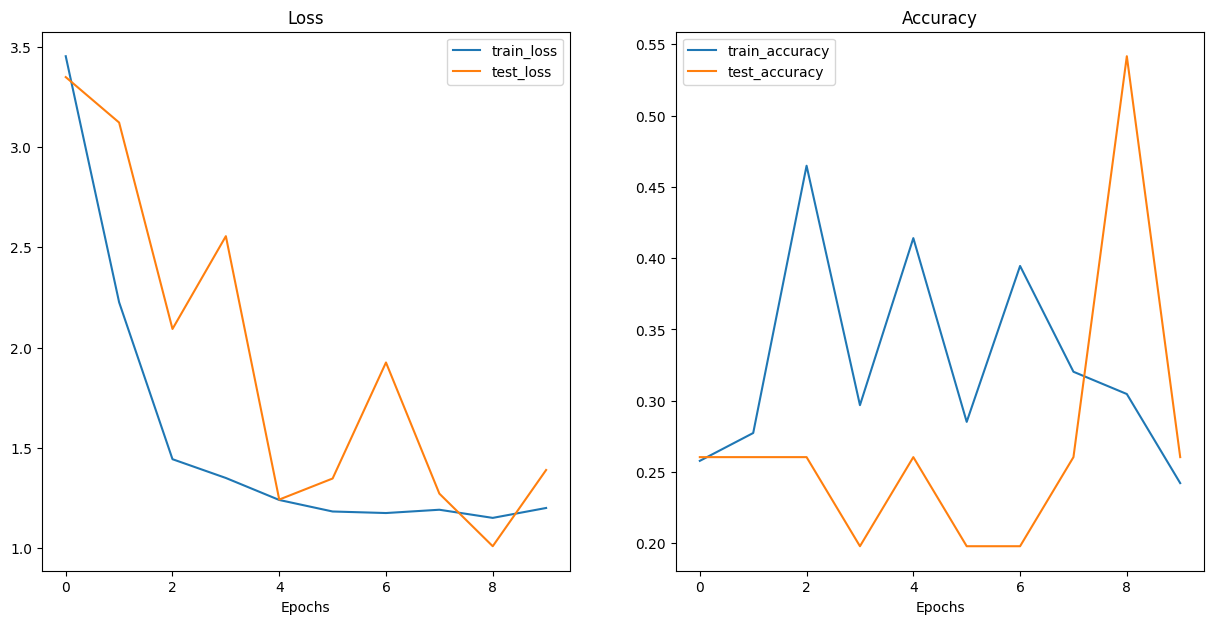

In [ ]:
from helper_functions import plot_loss_curves
# Plot our ViT model's loss curves
plot_loss_curves(results)

It is all over the plcae! Such ugliness, and from the look of the graph, we can tell it is underfitting

# 10. Using a pretraind ViT from torchvision.models on the same dataset

We'll use the pretraine models in 06.Pytorch Transfer Learning

## 10.1 Why pretrained model?

Short answer: cheap and effective

Long answer: To fully train a model which a size of ViT paper big, we need a "super" large setup. As of 2022, the price for renting a TPUv3 with 8 cores on Google cloud is $8 per hours, that mean it is cost **around 5,760 USD** a month!

## 10.2 Getting a pretrained ViT model and creating a feature extractor

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameters in pretrained_vit.parameters():
  parameters.requires_grad = False

# 4. Change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 104MB/s]


In [ ]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## 10.3 Setup data for the pretrained model


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:

#Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        transform=pretrained_vit_weights.transforms(),
                                                                                        batch_size=32)

In [ ]:
## 10.4 Train the features extractor Vit Model
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


Now we visualize

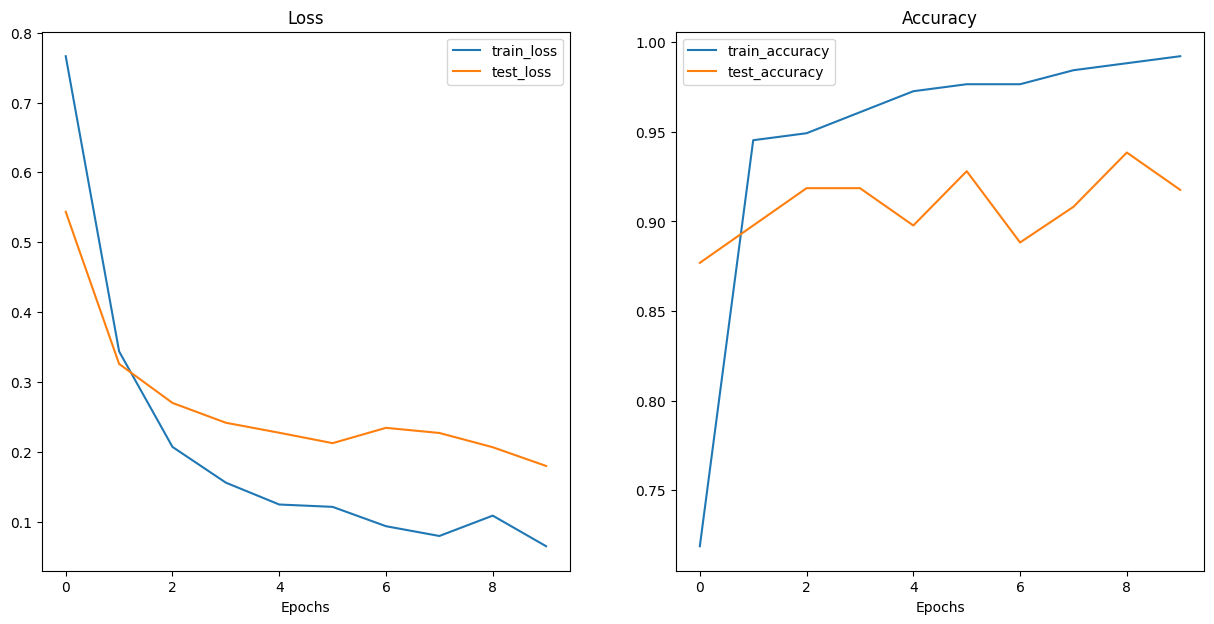

In [ ]:
plot_loss_curves(pretrained_vit_results)